In [258]:
import pandas as pd
import numpy as np
import math
from ast import literal_eval
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import gc
import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score

default_color = '#56B4E9'
colormap = plt.cm.cool

%matplotlib inline

In [254]:
#spend_train = pd.read_csv('data/spend_train.csv')

acq_train = pd.read_csv('data/acquisition_train.csv', parse_dates=True)
acq_test = pd.read_csv('data/acquisition_test.csv', parse_dates=True)

In [255]:
acq_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
ids                                                 45000 non-null object
target_default                                      41741 non-null object
score_1                                             44438 non-null object
score_2                                             44438 non-null object
score_3                                             44438 non-null float64
score_4                                             45000 non-null float64
score_5                                             45000 non-null float64
score_6                                             45000 non-null float64
risk_rate                                           44438 non-null float64
last_amount_borrowed                                15044 non-null float64
last_borrowed_in_months                             15044 non-null float64
credit_limit                                        31200 non-null flo

In [256]:
acq_train.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,...,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,...,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,4.500000e+04,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,...,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,...,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,4.030000e+02,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,...,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,5.094825e+04,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,...,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,1.017790e+05,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,...,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,1.513372e+05,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,...,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


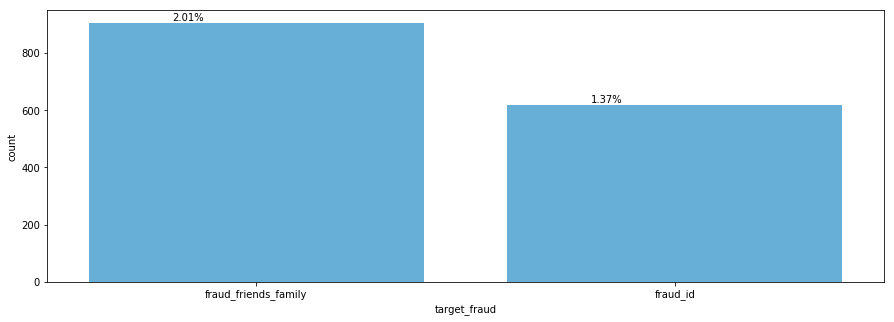

In [265]:
plt.figure(figsize=(15,5))

ax = sns.countplot('target_fraud',data=acq_train,color=default_color)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(acq_train['target_fraud'])), (p.get_x()+ 0.2, p.get_height()+10))

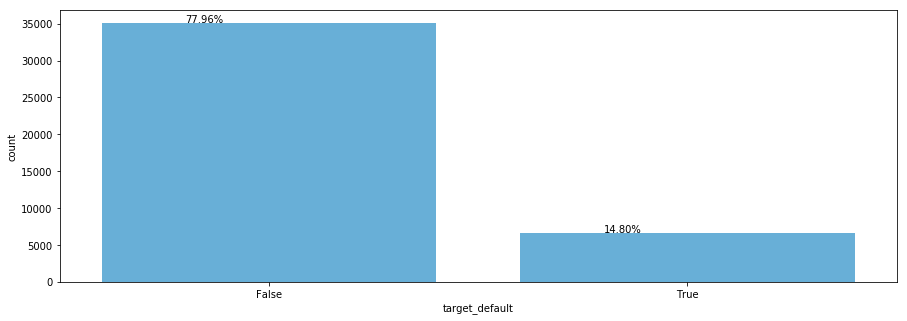

In [263]:
plt.figure(figsize=(15,5))

ax = sns.countplot('target_default',data=acq_train,color=default_color)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(acq_train['target_default'])), (p.get_x()+ 0.2, p.get_height()+100))

In [278]:
acq_train.columns.values.tolist()

['ids',
 'target_default',
 'score_1',
 'score_2',
 'score_3',
 'score_4',
 'score_5',
 'score_6',
 'risk_rate',
 'last_amount_borrowed',
 'last_borrowed_in_months',
 'credit_limit',
 'reason',
 'income',
 'facebook_profile',
 'state',
 'zip',
 'channel',
 'job_name',
 'real_state',
 'ok_since',
 'n_bankruptcies',
 'n_defaulted_loans',
 'n_accounts',
 'n_issues',
 'application_time_applied',
 'application_time_in_funnel',
 'email',
 'external_data_provider_credit_checks_last_2_year',
 'external_data_provider_credit_checks_last_month',
 'external_data_provider_credit_checks_last_year',
 'external_data_provider_email_seen_before',
 'external_data_provider_first_name',
 'external_data_provider_fraud_score',
 'lat_lon',
 'marketing_channel',
 'profile_phone_number',
 'reported_income',
 'shipping_state',
 'shipping_zip_code',
 'profile_tags',
 'user_agent',
 'target_fraud']

In [ ]:
def get_meta(train):
    data = []
    for col in train.columns:
        # Defining the role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'input'

        # Defining the level
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col or col == 'id':
            level = 'nominal'
        elif train[col].dtype == np.float64:
            level = 'interval'
        elif train[col].dtype == np.int64:
            level = 'ordinal'

        # Initialize keep to True for all variables except for id
        keep = True
        if col == 'id':
            keep = False

        # Creating a Dict that contains all the metadata for the variable
        col_dict = {
            'varname': col,
            'role'   : role,
            'level'  : level,
            'keep'   : keep,
            'dtype'  : dtype
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace=True)
    return meta


### Missings

In [266]:
missingValueColumns = acq_train.columns[acq_train.isnull().any()].tolist()
df_null = acq_train[missingValueColumns]

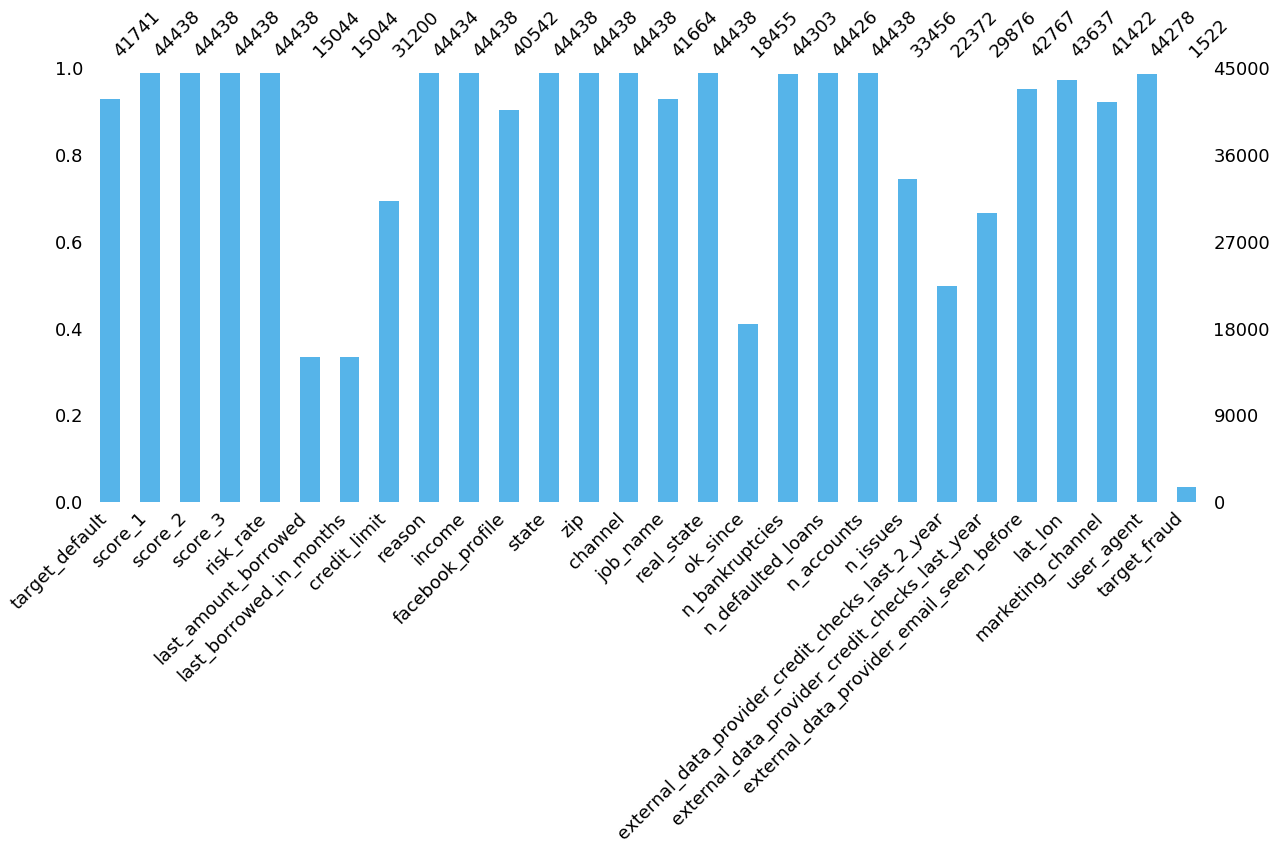

In [267]:
msno.bar(df_null,figsize=(20,8),color=default_color,fontsize=18,labels=True)

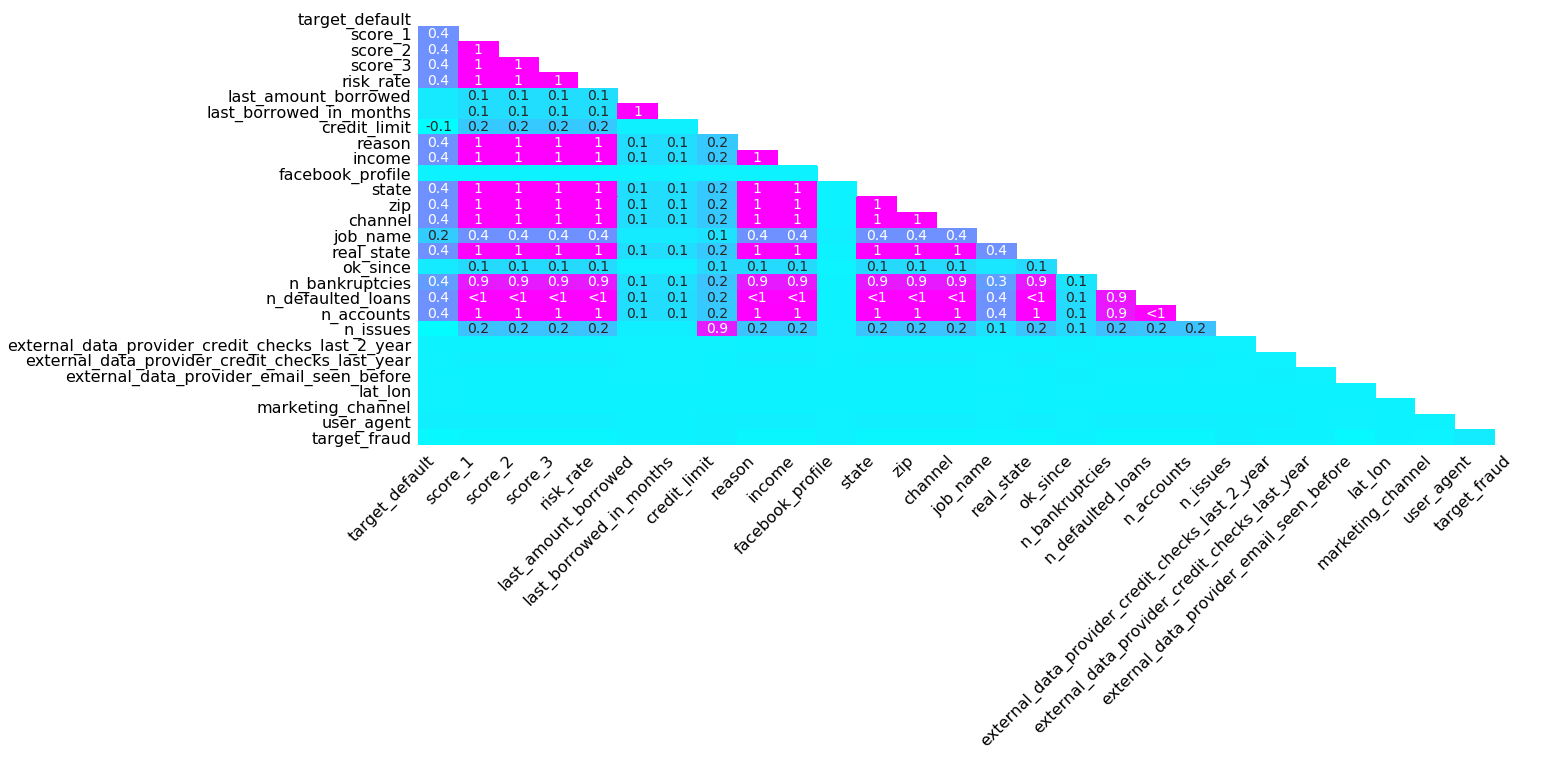

In [268]:
msno.heatmap(df_null,figsize=(20,8),cmap=colormap)

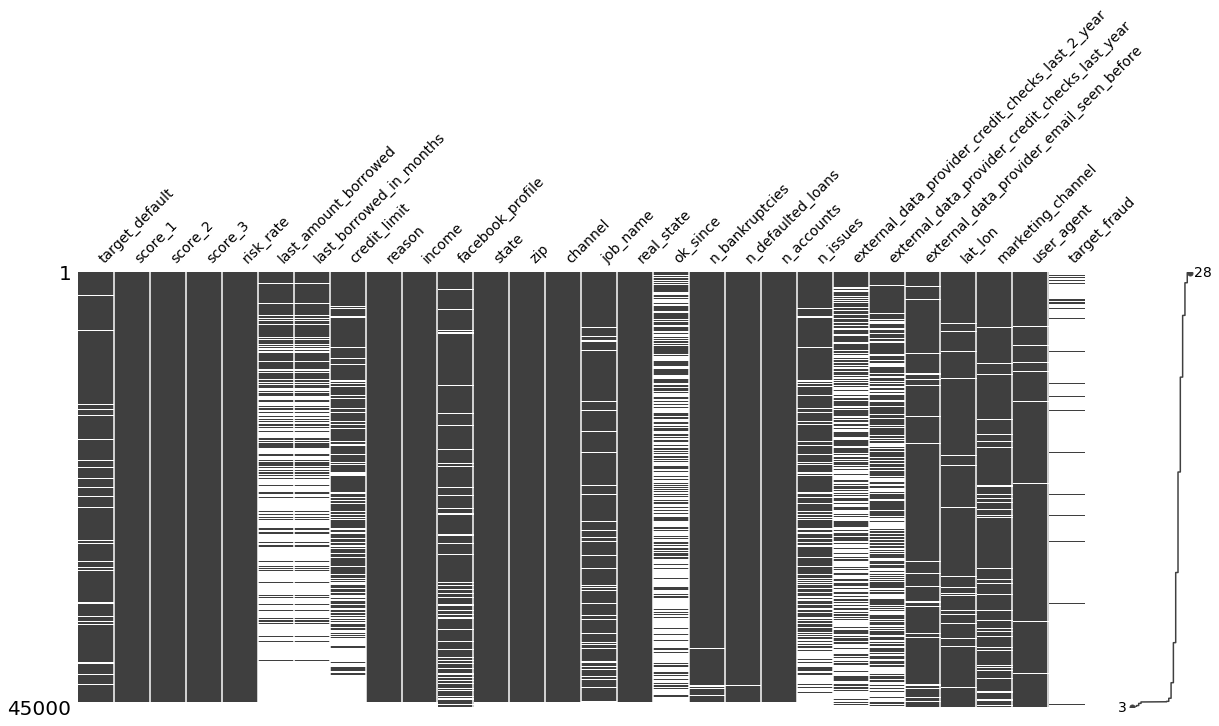

In [269]:
sorted_data = msno.nullity_sort(df_null, sort='descending') # or sort='ascending'
msno.matrix(sorted_data,figsize=(20,8),fontsize=14)

# My Procedures

In [136]:
# Data cleanup

def clean_replace(df, replace_dict):
    for key in replace_dict:
        for entry in replace_dict[key]:
            df[key].replace(entry[0],entry[1],inplace=True)
    

#categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
#df[LABELS] = df[LABELS].apply(categorize_label, axis=0)


# Scores 1 and 2 as categories
acq_train['score_1'] = acq_train['score_1'].astype('category').cat.codes
acq_train['score_2'] = acq_train['score_2'].astype('category').cat.codes

acq_test['score_1'] = acq_test['score_1'].astype('category').cat.codes
acq_test['score_2'] = acq_test['score_2'].astype('category').cat.codes

# Real State
acq_train['real_state'] = acq_train['real_state'].astype('category').cat.codes
acq_test['real_state'] = acq_test['real_state'].astype('category').cat.codes

# Parse lat_lon
# TODO: uncomment
acq_train['lat_lon'] = acq_train['lat_lon'].apply(lambda x: literal_eval(x) if pd.notnull(x) else x)
acq_test['lat_lon'] = acq_test['lat_lon'].apply(lambda x: literal_eval(x) if pd.notnull(x) else x)

acq_train[['lat','lon']] = acq_train['lat_lon'].apply(pd.Series)
acq_test[['lat','lon']] = acq_test['lat_lon'].apply(pd.Series)

# Fix email typos
replace_dict = {}
replace_dict['email'] = [['gmaill.com','gmail.com'],['hotmaill.com','hotmail.com']]

clean_replace(acq_train,replace_dict)
clean_replace(acq_test,replace_dict)

In [137]:
acq_train.groupby('email').count()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud,lat,lon
email,,,,,,,,,,,,,,,,,,,,,
gmail.com,22721,21035,22721,22721,22444,22721,22721,22721,22444,7571,...,20909,22721,22721,22721,22721,22721,22348,644,22036,22036
hotmail.com,11336,10505,11336,11336,11192,11336,11336,11336,11192,3846,...,10435,11336,11336,11336,11336,11336,11169,382,10997,10997
outlook.com,5797,5419,5797,5797,5717,5797,5797,5797,5717,1907,...,5343,5797,5797,5797,5797,5797,5704,359,5600,5600
spgov.com,5146,4782,5146,5146,5085,5146,5146,5146,5085,1720,...,4735,5146,5146,5146,5146,5146,5057,137,5004,5004


In [138]:
acq_train = acq_train[pd.notnull(acq_train["target_default"])]
acq_train["target_default"] = acq_train["target_default"].astype('int')

# Fill NA
acq_train["score_3"].fillna(acq_train["score_3"].mean(), inplace = True)
acq_test["score_3"].fillna(acq_test["score_3"].mean(), inplace = True)
acq_train["risk_rate"].fillna(acq_train["risk_rate"].mean(), inplace = True)
acq_test["risk_rate"].fillna(acq_test["risk_rate"].mean(), inplace = True)
acq_train["n_defaulted_loans"].fillna(0, inplace = True)
acq_test["n_defaulted_loans"].fillna(0, inplace = True)
acq_train["last_amount_borrowed"].fillna(0, inplace = True)
acq_test["last_amount_borrowed"].fillna(0, inplace = True)

acq_train["external_data_provider_credit_checks_last_year"].fillna(0, inplace = True)
acq_test["external_data_provider_credit_checks_last_year"].fillna(0, inplace = True)

# Early morning
parse_time_hour = lambda x: x.split(':')[0]
early_morning = lambda x: 1 if x <= 7 else 0

acq_train['application_hour_applied'] = pd.to_numeric(acq_train['application_time_applied'].apply(parse_time_hour)).replace(24,0)
acq_train['early_morning'] = acq_train['application_hour_applied'].apply(early_morning)
acq_test['application_hour_applied'] = pd.to_numeric(acq_test['application_time_applied'].apply(parse_time_hour)).replace(24,0)
acq_test['early_morning'] = acq_test['application_hour_applied'].apply(early_morning)

# Shipping state
acq_train['shipping_state'] = acq_train['shipping_state'].astype('category')
acq_test['shipping_state'] = acq_test['shipping_state'].astype('category')

acq_train['shipping_state'] = acq_train['shipping_state'].astype('category')
acq_test['shipping_state'] = acq_test['shipping_state'].astype('category')

In [ ]:
names = list(acq_train.groupby('target_fraud').count())
values = list(data.values())

#fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
#axs[0].bar(names, values)

/anaconda2/envs/challenge/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda2/envs/challenge/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


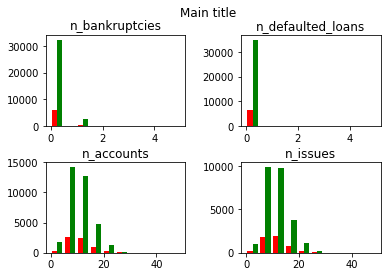

In [212]:
#TODO : add weights!
varlist = ['n_bankruptcies','n_defaulted_loans','n_accounts','n_issues']

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, a in enumerate(varlist):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(a, fontsize='large')
    fig.suptitle('Main title')
    ax.hist([acq_train[acq_train['target_default']==1][a], acq_train[acq_train['target_default']==0][a]], color = ['r','g'])

In [213]:
[acq_train[acq_train['target_default']==1][a], acq_train[acq_train['target_default']==0][a]]

[2         NaN
 9         8.0
 26       16.0
 30        7.0
 31       22.0
 34        NaN
 35        7.0
 37       13.0
 44        NaN
 45       23.0
 48       17.0
 54        8.0
 77       15.0
 88       10.0
 92       10.0
 93       12.0
 107      19.0
 118       NaN
 136       6.0
 137      14.0
 150       NaN
 156      11.0
 158       8.0
 159       9.0
 160      13.0
 168       9.0
 170      15.0
 172       7.0
 176       NaN
 178       8.0
          ... 
 44814     8.0
 44819     9.0
 44820    12.0
 44825     7.0
 44830     9.0
 44836    12.0
 44843     8.0
 44848     NaN
 44850     9.0
 44852     6.0
 44857    14.0
 44860     9.0
 44868     9.0
 44879    10.0
 44883     9.0
 44887     NaN
 44893    17.0
 44897    12.0
 44912     9.0
 44915     6.0
 44924    15.0
 44940     9.0
 44955     4.0
 44963    13.0
 44965     NaN
 44970    13.0
 44975     7.0
 44985     NaN
 44991     NaN
 44998    10.0
 Name: n_issues, Length: 6661, dtype: float64, 0        18.0
 1        14.0
 3       

In [44]:
acq_train[(~acq_train['target_fraud'].isna())].groupby(['early_morning']).count()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud,application_hour_applied,application_minute_applied,application_second_applied
early_morning,,,,,,,,,,,,,,,,,,,,,
0,513,460,504,504,504,513,513,513,504,158,...,513,513,513,513,513,513,513,513,513,513
1,1009,897,983,983,983,1009,1009,1009,983,351,...,1009,1009,1009,1009,1009,1007,1009,1009,1009,1009


In [ ]:
acq_train[~acq_train['target_fraud'].isna()]['application_hour_applied'].hist()

## Plots

## Fraud / Default

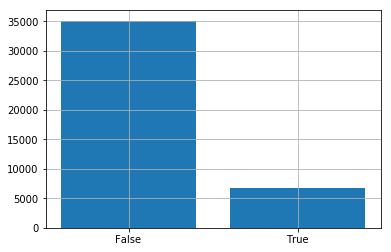

In [184]:
feat = 'target_default'
vals = list(acq_train[feat].unique())
names = ['True' if (i == 1) else 'False' for i in vals ]
values = [sum(acq_train[feat]==i) for i in vals]

plt.bar(names, values)
plt.grid()

#print(vals)
#print(names)
#print(values)

In [230]:
for i in acq_train[feat].unique():
   print(acq_train[acq_train[feat]==i].shape)

(35080, 47)
(6661, 47)


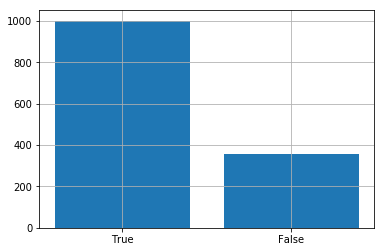

In [224]:
# Fraud and default

feat = 'target_default'
vals = list(acq_train[~acq_train['target_fraud'].isna()][feat].unique())
names = ['True' if (i == 1) else 'False' for i in vals ]
values = [sum(acq_train[~acq_train['target_fraud'].isna()][feat]==i) for i in vals]

plt.bar(names, values)
plt.grid()

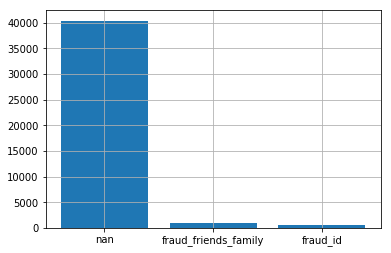

In [222]:
feat = 'target_fraud'
vals = [str(i) for i in list(acq_train[feat].unique())]
types = [type(v) for v in vals]
names = ['True' if (i == 'nan') else 'False' for i in vals ]
values = [sum(acq_train[feat]==i) if i != 'nan' else acq_train[feat].isna().sum() for i in vals]

plt.bar(vals, values)
plt.grid()

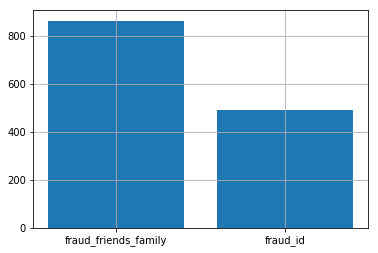

In [211]:
plt.bar(vals[1:], values[1:])
plt.grid()

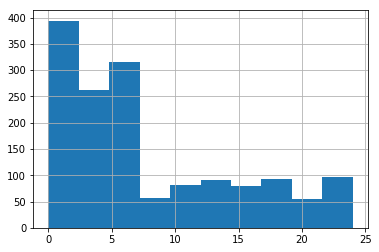

In [28]:
acq_train[~acq_train['target_fraud'].isna()]['application_hour_applied'].hist()

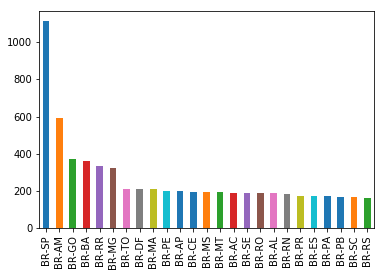

In [78]:
acq_train[acq_train['target_default']==True]['shipping_state'].value_counts().plot(kind='bar')

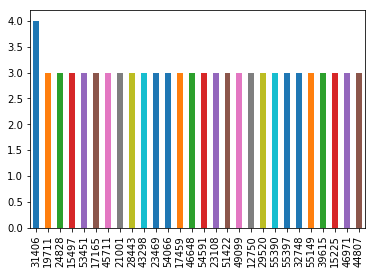

In [13]:
acq_train[(acq_train['target_default']==True)].\
    groupby(['shipping_zip_code']).\
    filter(lambda x: len(x) > 2)['shipping_zip_code'].value_counts().plot(kind='bar')

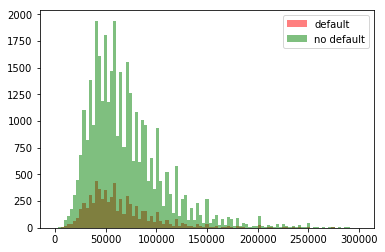

In [240]:
#limit = acq_train['income'].max()
limit = 300000
income_default = acq_train[(acq_train['target_default']==True) & (acq_train['income']< limit)]['income'].values.tolist()
income_nodefault = acq_train[(~acq_train['target_default']) & (acq_train['income']< limit)]['income'].values.tolist()

bins = np.linspace(0, limit, 100)

plt.hist(income_default, bins, alpha=0.5, label='default', color='red')
plt.hist(income_nodefault, bins, alpha=0.5, label='no default', color='green')
plt.legend(loc='upper right')

### Mapa

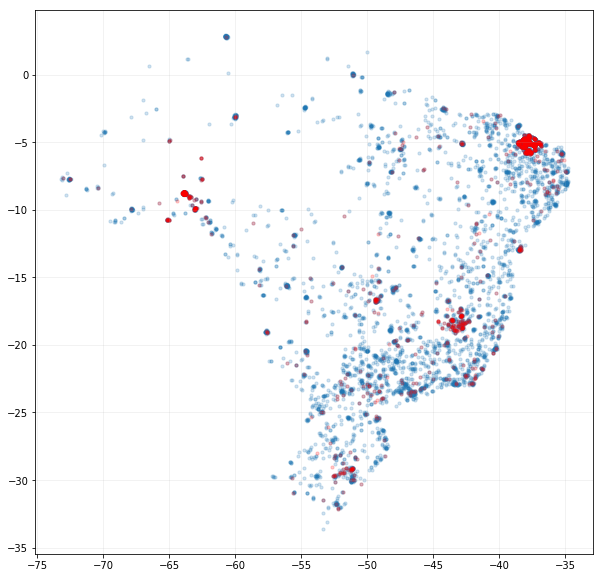

In [150]:

fig = plt.figure(figsize=(10, 10))

# 2. scatter city data, with color reflecting population
# and size reflecting area
plt.scatter(acq_train[acq_train['target_default']==True]['lon'], 
            acq_train[acq_train['target_default']==True]['lat'],
          cmap='Reds', alpha=0.2, s=10)

plt.scatter(acq_train[~acq_train['target_fraud'].isna()]['lon'], 
            acq_train[~acq_train['target_fraud'].isna()]['lat'],
          cmap='Reds', alpha=0.2, s=10,c='r')

plt.grid(alpha=0.2)

#plt.scatter(acq_train[acq_train['target_default']==0]['lon'], 
#            acq_train[acq_train['target_default']==0]['lat'],
#          cmap='Reds', alpha=0.1, s=10)

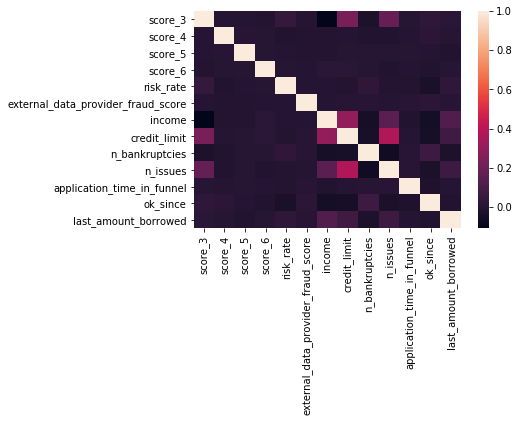

In [237]:
variables = ['score_3', 'score_4', 'score_5', 'score_6', 'risk_rate', 'external_data_provider_fraud_score', 'income', 'credit_limit', 'n_bankruptcies', 'n_issues', 'application_time_in_funnel', 'ok_since', 'last_amount_borrowed']
import seaborn as sns
corr = acq_train[variables].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
'''
df = df[['STNAME','CTYNAME']].groupby(['STNAME'])['CTYNAME'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(5)
'''

In [28]:
acq_train.groupby(['external_data_provider_credit_checks_last_year']).count()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud,lat,lon
external_data_provider_credit_checks_last_year,,,,,,,,,,,,,,,,,,,,,
0.0,13744,13744,13744,13744,13744,13744,13744,13744,13744,13744,...,12652,13744,13744,13744,13744,13744,13550,431,13324,13324
1.0,13976,13976,13976,13976,13976,13976,13976,13976,13976,13976,...,12866,13976,13976,13976,13976,13976,13731,456,13564,13564


## Model

In [252]:
acq_train[variables].isnull().any()

score_3                               False
score_4                               False
score_5                               False
score_6                               False
early_morning                         False
external_data_provider_fraud_score    False
income                                False
reported_income                       False
application_time_in_funnel            False
dtype: bool

In [243]:
acq_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41741 entries, 0 to 44999
Data columns (total 47 columns):
ids                                                 41741 non-null object
target_default                                      41741 non-null int64
score_1                                             41741 non-null int8
score_2                                             41741 non-null int8
score_3                                             41741 non-null float64
score_4                                             41741 non-null float64
score_5                                             41741 non-null float64
score_6                                             41741 non-null float64
risk_rate                                           41741 non-null float64
last_amount_borrowed                                41741 non-null float64
last_borrowed_in_months                             14133 non-null float64
credit_limit                                        28632 non-null float64


In [276]:
# Perform the necessary imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

variables = ['score_3', 'score_4', 'score_5', 'score_6', 'early_morning', 'external_data_provider_fraud_score', 'income', 'application_time_in_funnel']

# Fit the pipeline to 'samples'
#pipeline.fit(acq_train[variables])

# TODO TREAT VARIABLES

# Plot the explained variances
#features = range(pca.n_components_)
#plt.bar(features, pca.explained_variance_)
#plt.xlabel('PCA feature')
#plt.ylabel('variance')
#plt.xticks(features)
#plt.show()


In [46]:
#var_all = acq_train.keys().values.tolist()
var_all = [
 'score_1',
 'score_2',
 'score_3',
 'score_4',
 'score_5',
 'score_6',
 'risk_rate',
 'last_amount_borrowed',
 'last_borrowed_in_months',
 'credit_limit',
# 'reason',
 'income',
 'facebook_profile',
# 'state',
# 'real_state',
# 'n_bankruptcies',
# 'n_defaulted_loans',
# 'n_accounts',
# 'n_issues',
# 'application_time_applied',
# 'application_time_in_funnel',
# 'email',
 'external_data_provider_credit_checks_last_2_year',
 'external_data_provider_credit_checks_last_month',
 'external_data_provider_credit_checks_last_year',
# 'external_data_provider_email_seen_before',
 'external_data_provider_fraud_score',
# 'marketing_channel',
# 'reported_income',
# 'lat',
# 'lon'
]

In [236]:
acq_train.ok_since.head()

0     NaN
1    50.0
2     NaN
3     NaN
4     NaN
Name: ok_since, dtype: float64

In [141]:
variables = ['score_1','score_2','score_3', 'score_4', 'score_6', 'risk_rate', 'early_morning']

from sklearn.model_selection import train_test_split

X_all = acq_train[variables]
#X_all = acq_train[var_all]
y_all = acq_train['target_default']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=42)

In [142]:

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
run_gs = True
if run_gs:
    parameters = {'n_estimators': [4, 6, 9], 
                  'max_features': ['log2', 'sqrt','auto'], 
                  'criterion': ['entropy', 'gini'],
                  'max_depth': [3, 5, 10], 
                  'min_samples_split': [5,8,10],
                  'min_samples_leaf': [5,8,10]
                 }
else: 
     parameters = {'n_estimators': [9], 
                  'max_features': ['sqrt'], 
                  'criterion': ['gini'],
                  'max_depth': [5], 
                  'min_samples_split': [5],
                  'min_samples_leaf': [8]
                 }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=5)
grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

#RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=8, min_samples_split=5,
#            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
#            oob_score=False, random_state=None, verbose=0,
#            warm_start=False)

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [143]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))
print(roc_auc_score(y_test,predictions))

0.848844172955
0.500791139241


In [144]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(base_estimator = clf, n_estimators = 8)
model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          learning_rate=1.0, n_estimators=8, random_state=None)

In [145]:
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(roc_auc_score(y_test,predictions))

0.848484848485
0.504804398221


In [27]:
y_test = y_test.reset_index()

In [145]:
idx = [y_test['index'].loc[i] for i in range(len(predictions)) if predictions[i] != y_test['target_default'].loc[i]]

In [147]:
X_test.loc[44104]

score_1        3.000000
score_2        9.000000
score_3      200.000000
score_4       93.662160
score_6       82.053903
risk_rate      0.200000
Name: 44104, dtype: float64

### LightGBM

In [61]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/anaconda2/envs/challenge/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/envs/challenge/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda2/envs/challenge/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [62]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf2 = lgb.train(params, d_train, 100)

In [63]:
y_pred=clf2.predict(X_test)
predictions = []
#convert into binary values
for i in range(y_pred.shape[0]):
    if y_pred[i]>=.5:       # setting threshold to .5
        predictions.append(True)
    else:  
        predictions.append(False)

In [66]:
print(accuracy_score(y_test, predictions))
print(roc_auc_score(y_test,predictions))

0.848604623308
0.5


# NOVO

In [274]:

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(acq_train.drop(['target_default','target_fraud'],axis=1), acq_train.target_default)
features = acq_train.drop(['target_default','target_fraud'],axis=1).columns.values
print("----- Training Done -----")

ValueError: could not convert string to float: 'Mozilla/5.0 (iPhone; CPU iPhone OS 11_0 like Mac OS X) AppleWebKit/604.1.38 (KHTML, like Gecko) Version/11.0 Mobile/15A372 Safari/604.10'